In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

In [2]:
vector.register_awkward() 

In [3]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/JIjQaAYEQnmRDkX/291694/AnalysisResults.root' > run291694.data.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100M  100  100M    0     0  1321k      0  0:01:17  0:01:17 --:--:--  768k0   366k      0  0:04:40  0:00:30  0:04:10  941k


In [5]:
!file *.root
file = uproot.open("run291694.data.root")
file.keys()
events = file["eventsTree"]
events.show()

run290223.data.root: ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4

iinf :  51 isup :  141


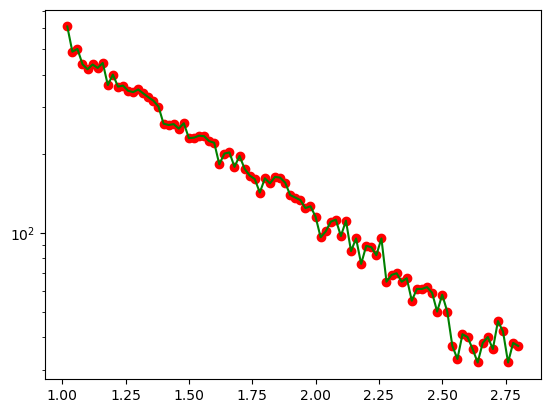

In [6]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit

vector.register_awkward() 

DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hInvMass:hist.Hist, hQualInvMass:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """

    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[0:5]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] #selection des évènements CMUL
        tracks = getTracks(events) #on utilise la fonction getTracks définie précédemment
        goodTracks=tracks[trackSelector(tracks)] #selection des évènements (eta, theta et trigger)
        
        #pairs = ak.combinations(goodTracks, 2)
        #one, two = ak.unzip(pairs)
        #rapidity_cut = (abs(one.eta<4)) & (abs(one.eta>2))
        #opposite_charge_cut = (one.charge + two.charge == 0) & (abs(one.eta<2))
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        #invariant_mass = (quality_one + quality_two).mass
        
        pairs = ak.combinations(goodTracks, 2) #toutes les combinaisons de 2 traces
        one, two = ak.unzip(pairs)
        quality_one, quality_two = ak.unzip(pairs[(one.charge + two.charge == 0) & (abs(one.eta) <4) & (abs(one.eta)>2.5) 
                                                 & (abs(two.eta)<4) & (abs(two.eta)>2.5)]) #selection pairs signes opposées et y dans l'acceptance
        invariant_mass = (one + two).mass #masse invariante sans distinction des good pairs
        quality_invariant_mass = (quality_one + quality_two).mass #masse invariante avec correction
    
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi)) 
        hInvMass.fill(ak.flatten(invariant_mass))
        hQualInvMass.fill(ak.flatten(quality_invariant_mass))


        if verbose:
            print(batch[1])


def NoiseVWG(x, mu, alpha, beta, N):
    y = np.array([], dtype=float)
    for i in x:
        sigma = alpha + beta*((i-mu)/mu)
        y = np.append(y, N * np.exp(-((i-mu)**2)/(2*sigma**2)))
    return y

def NoisePR(x, a1, b1, b2, N):
    y = np.array([], dtype=float)
    for i in x:
        y = np.append(y, N*(1 + a1*i)/(b1*i + b2*i))
    return y
        
def NoiseDE(x, alpha, beta1, beta2, N):
    y = np.array([], dtype=float)
    for i in x:
        y = np.append(y, N*(np.exp(beta1*i) + alpha*np.exp(beta2*i)))
    return y
    
    
## SINGLE MUON TRACK PLOTS
#No cuts
vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMass = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass'))
vhQualInvMass = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass with good pairs'))
#Event selection
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass'))
vhQualInvMassEvSel = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=5,name='invariant mass with good pairs'))


scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hInvMass=vhInvMass, hQualInvMass=vhQualInvMass)

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel, hInvMass=vhInvMassEvSel, hQualInvMass=vhQualInvMassEvSel,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4) & (x["thetaAbs"]>2) & (x["thetaAbs"]<9) & (x["matched"]==2))    
    
x_data=[]
y_data=[]
iinf = 0
isup = 0
      
for i in range(0,5000,20):
    x_data.append(i/1000)

for i in vhQualInvMassEvSel:
      y_data.append(i)
        
for i in range(0, 5000, 20):
    if (i/1000. > 1. ):
        iinf = int(i/20)
        break

for i in range(0, 5000, 20):
    if (i/1000. > 2.8):
        isup = int(i/20)
        break
        
print("iinf : ", iinf, "isup : ", isup)        

x_data_sorted = x_data[iinf:isup]
y_data_sorted = y_data[iinf:isup]
        
plt.plot(x_data_sorted,y_data_sorted,'g')
plt.scatter(x_data_sorted,y_data_sorted,c = 'red')
plt.yscale("log")
plt.show()

[7.18998714e-07 4.91666679e-01 1.36376755e-07 1.57858391e+03]


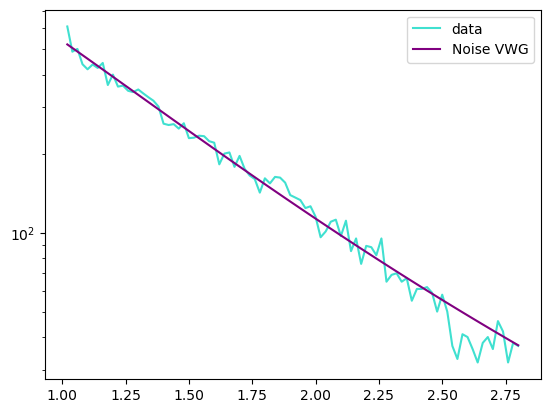

In [7]:
fit1, cov1 = curve_fit(NoiseVWG, x_data_sorted, y_data_sorted)
print(fit1)
y_fit1 = NoiseVWG(x_data_sorted, float(fit1[0]), float(fit1[1]), float(fit1[2]), float(fit1[3]))

plt.semilogy(x_data_sorted, y_data_sorted, color="turquoise", label="data")
plt.semilogy(x_data_sorted, y_fit1, color="purple", label="Noise VWG")
plt.legend()
plt.show()

/home/jimushoko/miniforge3/envs/qqbar2mumu/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-7.23297594e+04 -5.36767429e+02 -4.78775098e+02  2.48936490e+00]


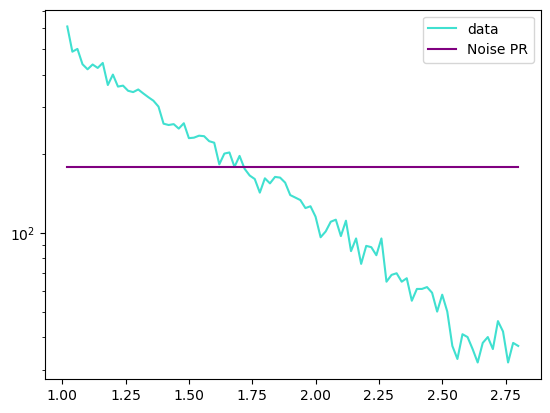

In [8]:
fit2, cov2 = curve_fit(NoisePR, x_data_sorted, y_data_sorted, maxfev=10000)
print(fit2)
y_fit2 = NoisePR(x_data_sorted, float(fit2[0]), float(fit2[1]), float(fit2[2]), float(fit2[3]))

plt.semilogy(x_data_sorted, y_data_sorted, color="turquoise", label="data")
plt.semilogy(x_data_sorted, y_fit2, color="purple", label="Noise PR")
plt.legend()
plt.show()

In [9]:
fit3, cov3 = curve_fit(NoiseDE, x_data_sorted, y_data_sorted, maxfev=50000)
print(fit3)
y_fit3 = NoiseDE(x_data_sorted, float(fit3[0]), float(fit3[1]), float(fit3[2]), float(fit3[3]))

plt.semilogy(x_data_sorted, y_data_sorted, color="turquoise", label="data")
plt.semilogy(x_data_sorted, y_fit3, color="purple", label="Noise DE")
plt.legend()
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 50000.